In [1]:
import matplotlib.pyplot as plt
from lasy.laser import Laser
# from lasy.profiles.gaussian_profile import GaussianProfile
from lasy import profiles
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

from PIL import Image
import scipy 

import scipy 
import PIL
from lasy.utils.zernike import zernike

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    
def showxy(laser, **kw):
    """
    Show a 2D image of the laser amplitude.

    Parameters
    ----------
    **kw: additional arguments to be passed to matplotlib's imshow command
    """
    temporal_field = laser.grid.get_temporal_field()
    i_slice = int(temporal_field.shape[-1] // 2)
    E = temporal_field[:,:,  i_slice]
    extent = [
            laser.grid.lo[1],
            laser.grid.hi[1],
            laser.grid.lo[0],
            laser.grid.hi[0],
        ]

    plt.imshow(abs(E), extent=extent, aspect="auto", origin="lower", **kw)
    cb = plt.colorbar()
    cb.set_label("$|E_{envelope}|$ (V/m)")
    plt.xlabel("y (m)")
    plt.ylabel("x (m)")


In [2]:
import time
import aotools
import numpy as np
from scipy import fftpack
from astropy.io import fits
from soapy import SCI, confParse
from matplotlib import pyplot as plt
import os
import sys
import warnings
wavelength=800*1e-9
warnings.filterwarnings("ignore", category=DeprecationWarning) 
with np.errstate(invalid='ignore'):
    np.random.seed(seed=1)

    n_psfs = 1000                                     # Number of PSFs
    n_zernike = 100                                # Number of Zernike polynomials

                                # Number of Zernike polynomials
    i_zernike = np.arange(2, n_zernike + 2)         # Zernike polynomial indices (piston excluded)
    o_zernike= []                                   # Zernike polynomial radial Order, see J. Noll paper :
    for i in range(1,n_zernike):                    # "Zernike polynomials and atmospheric turbulence", 1975
        for j in range(i+1):
            if len(o_zernike) < n_zernike:
                o_zernike.append(i)

    # Generate randomly Zernike coefficient. By dividing the value

    # by its radial order we produce a distribution following
    # the expected 1/f^-2 law.
    c_zernike = 2 * np.random.random((10*n_psfs, n_zernike)) - 1
    for j in range(n_psfs):
        for i in range(n_zernike):
            c_zernike[j, i] = c_zernike[j, i] / o_zernike[i]

    c_zernike = np.array([c_zernike[k, :] / np.abs(c_zernike[k, :]).sum()* wavelength*(10**9)
                           for k in range(1*n_psfs)])
    zernike_basis = aotools.zernikeArray(n_zernike + 1,256, norm='rms')
    print(zernike_basis)
    zernike_basis = aotools.zernikeArray(n_zernike + 1, 256, norm='nol')
    print(zernike_basis)

    #print

/rds/general/user/jh2619/home/anaconda3/lib/python3.10/site-packages/aotools/functions/karhunenLoeve.py:30: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates
/rds/general/user/jh2619/home/anaconda3/lib/python3.10/site-packages/soapy-0.14.0+8.g6c981a6-py3.10.egg/soapy/DM.py:47: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import rotate


[[[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-0. -0. -0. ...  0.  0.  0.]
  [-0. -0. -0. ...  0.  0.  0.]
  [-0. -0. -0. ...  0.  0.  0.]
  ...
  [-0. -0. -0. ...  0.  0.  0.]
  [-0. -0. -0. ...  0.  0.  0.]
  [-0. -0. -0. ...  0.  0.  0.]]

 [[-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]]

 [[-0. -0. -0. ...  0.  0.  0.]
  [-0. -0. -0. ...  0.  0.  0.]
  [-0. -0. -0. ...  0.  0.  0.]
  ...
  [-0. -0. -0. ...  0.  0.  0.]
  [-0. -0. -0. ...  0.  0.  0.]
  [-0. -0. -0. ...  0.  0.  

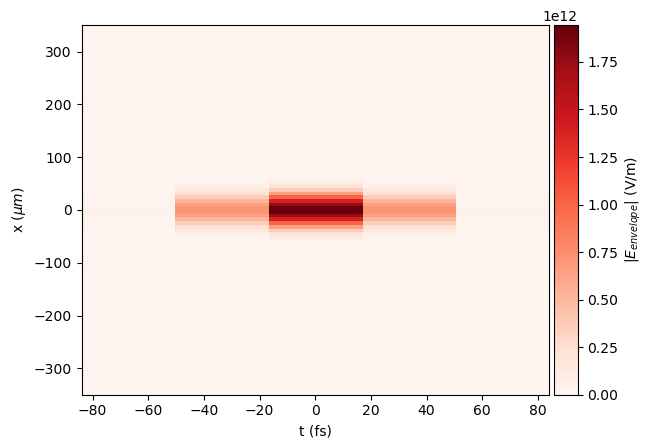

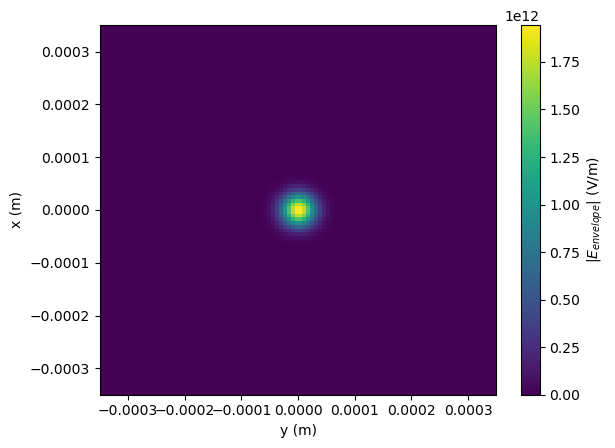

In [3]:
from lasy.utils.zernike import zernike
from lasy.laser import Laser
from lasy import profiles
from lasy.optical_elements import ParabolicMirror, ZernikeAberrations
from copy import deepcopy
# from lasy.profiles.gaussian_profile import GaussianProfile

wavelength = 800e-9  # Laser wavelength in meters
polarization = (1, 0)  # Linearly polarized in the x direction
energy = 0.4  # Energy of the laser pulse in joules
spot_size = 30e-6  # Waist of the laser pulse in meters
WndowSz=350e-6
tau = 42e-15  # Pulse duration of the laser in seconds
t_peak = 0.0  # Location of the peak of the laser pulse in time
f0=18*1e-3


ls_profile=profiles.GaussianProfile(w0=spot_size, wavelength=wavelength, tau=tau, t_peak=t_peak, laser_energy=0.4, pol=polarization )
lo = (- WndowSz,-WndowSz,  -2 * tau)  # Lower bounds of the simulation box
hi = (WndowSz,WndowSz, 2 * tau)  # Upper bounds of the simulation box
num_points = (100, 100, 5)  # Number of points in each dimension
pupil_coords=(0, 0, 300*1e-6)
laser = Laser('xyt', lo, hi, num_points, ls_profile)
laser.show()
plt.show()
showxy(laser)
plt.show()


sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
sh: scl: line 1: syntax error: unexpected end of file
sh: error importing function definition for `scl'
sh: ml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `ml'
rmdir: failed to remove 'outEx': Directory not empty
sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
sh: scl: line 1: syntax error: unexpected end of file
sh: error importing function definition for `scl'
sh: ml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `ml'


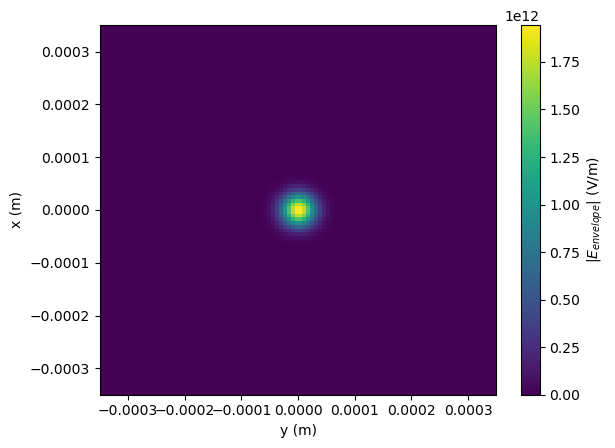

(100, 100)


  0%|          | 00:00<? [?it/s]

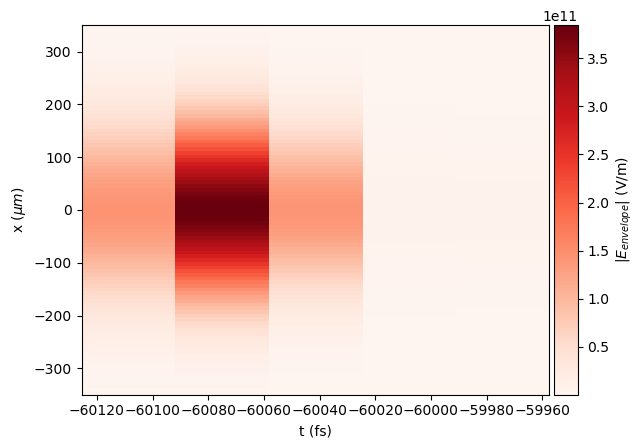

(1000, 100)


  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

In [4]:
outFIl='outEx'
os.system('rmdir '+outFIl)
os.system('mkdir -p '+outFIl)
iii=0
pupil_coords=(0, 0, 200*1e-6)
ls11=deepcopy(laser)
im=showxy(ls11)
plt.show()
temporal_field = ls11.grid.get_temporal_field()
i_slice = int(temporal_field.shape[-1] // 2)
E = temporal_field[:,:,  i_slice]
extent = [
        laser.grid.lo[1],
        laser.grid.hi[1],
        laser.grid.lo[0],
        laser.grid.hi[0],
    ]
print(np.shape(E))
norm=abs(E)**2 #[30:-30, 30:-30]
#     norm=np.pad(norm, 3, pad_with, padder=0)
#     print(np.shape(norm))
norm=scipy.ndimage.zoom(norm, 128/np.shape(norm)[0], order=0)

ls11.propagate(-18*1e-3)
# showxy(ls11)
ls11.show()
plt.show()
print(np.shape(c_zernike))
for i, c in enumerate(c_zernike):

    ls1=deepcopy(ls11)

    WFE=np.random.randint(10, 30)
#     print(WFE)
    zernike_amplitudes = {index: value*WFE*1e-3 for index, value in enumerate(c)}
#     print(zernike_amplitudes)
#     np.squeeze(np.sum(c_zernike[i, :, None, None] * WFE*zernike_basis[1:, :, :], axis=0))
#     aberrations_in = np.squeeze(np.sum(c_zernike[i, :, None, None]* WFE*1e-3*zernike_basis[1:, :, :], axis=0))
#     plt.imshow(aberrations_in)
#     plt.show()
    phs=aotools.functions.zernike.phaseFromZernikes(c*WFE*1e-3, 128, norm='rms')
#     plt.imshow(phs)
#     plt.show()
    aberrations_in=phs
#     print(aberrations_in)
#     print(c_zernike[i, :, None, None])
#     print(zernike_basis[1:, :, :])
    znk=ZernikeAberrations(pupil_coords, zernike_amplitudes)
     
    ls1.apply_optics(znk)
    ls1.propagate(18*1e-3)
    temporal_field = ls1.grid.get_temporal_field()
    i_slice = int(temporal_field.shape[-1] // 2)
    E = temporal_field[:,:,  i_slice]
    extent = [
            laser.grid.lo[1],
            laser.grid.hi[1],
            laser.grid.lo[0],
            laser.grid.hi[0],
        ]
#     print(np.shape(E))
    norm=abs(E)**2 #[30:-30, 30:-30]

    
#     norm=np.pad(norm, 3, pad_with, padder=0)
#     print(np.shape(norm))
    norm=scipy.ndimage.zoom(norm, 128/np.shape(norm)[0], order=0)
#     print(norm)
#     print('Final Saved Product')
#     plt.imshow(norm)
#     plt.colorbar()
#     plt.show()

#     plt.imshow(norm)
#     plt.colorbar()
#     plt.show()
    
    outfile = outFIl+"/psf_" + str(iii) + ".fits"
    hdu_primary = fits.PrimaryHDU(c.astype(np.float32))
    hdu_phase = fits.ImageHDU(aberrations_in.astype(np.float32), name='PHASE')
    hdu_In = fits.ImageHDU(norm.astype(np.float32), name='INFOCUS')
    hdu_Out = fits.ImageHDU(norm.astype(np.float32), name='OUTFOCUS')
    hdu = fits.HDUList([hdu_primary, hdu_phase, hdu_In, hdu_Out])
    hdu.writeto(outfile, overwrite=True)
    iii+=1

sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
sh: scl: line 1: syntax error: unexpected end of file
sh: error importing function definition for `scl'
sh: ml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `ml'
sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
sh: scl: line 1: syntax error: unexpected end of file
sh: error importing function definition for `scl'
sh: ml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `ml'


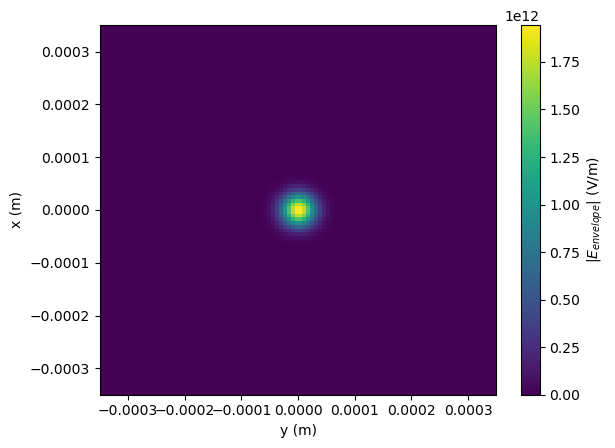

(100, 100)


  0%|          | 00:00<? [?it/s]

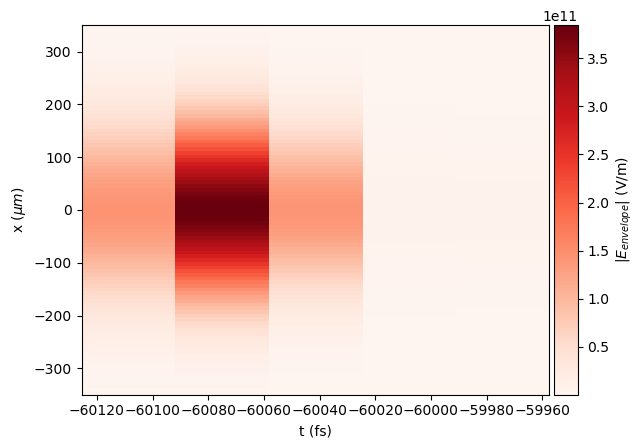

(1000, 100)


  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

In [29]:
from PIL import Image


outFIl='outIms'
os.system('mkdir -p '+outFIl+'/Val_Phase')
os.system('mkdir -p '+outFIl+'/Val_Focus')

iii=0
pupil_coords=(0, 0, 200*1e-6)
ls11=deepcopy(laser)
im=showxy(ls11)
plt.show()
temporal_field = ls11.grid.get_temporal_field()
i_slice = int(temporal_field.shape[-1] // 2)
E = temporal_field[:,:,  i_slice]
extent = [
        laser.grid.lo[1],
        laser.grid.hi[1],
        laser.grid.lo[0],
        laser.grid.hi[0],
    ]
print(np.shape(E))
norm=abs(E)**2 #[30:-30, 30:-30]
#     norm=np.pad(norm, 3, pad_with, padder=0)
#     print(np.shape(norm))
norm=scipy.ndimage.zoom(norm, 128/np.shape(norm)[0], order=0)

ls11.propagate(-18*1e-3)
# showxy(ls11)
ls11.show()
plt.show()
print(np.shape(c_zernike))
for i, c in enumerate(c_zernike):

    ls1=deepcopy(ls11)

    WFE=np.random.randint(10, 30)
#     print(WFE)
    zernike_amplitudes = {index: value*WFE*1e-3 for index, value in enumerate(c)}
#     print(zernike_amplitudes)
#     np.squeeze(np.sum(c_zernike[i, :, None, None] * WFE*zernike_basis[1:, :, :], axis=0))
#     aberrations_in = np.squeeze(np.sum(c_zernike[i, :, None, None]* WFE*1e-3*zernike_basis[1:, :, :], axis=0))
#     plt.imshow(aberrations_in)
#     plt.show()
    phs=aotools.functions.zernike.phaseFromZernikes(c*WFE*1e-3, 128, norm='rms')
#     plt.imshow(phs)
#     plt.show()
    aberrations_in=phs
#     print(aberrations_in)
#     print(c_zernike[i, :, None, None])
#     print(zernike_basis[1:, :, :])
    znk=ZernikeAberrations(pupil_coords, zernike_amplitudes)
     
    ls1.apply_optics(znk)
    ls1.propagate(18*1e-3)
    temporal_field = ls1.grid.get_temporal_field()
    i_slice = int(temporal_field.shape[-1] // 2)
    E = temporal_field[:,:,  i_slice]
    extent = [
            laser.grid.lo[1],
            laser.grid.hi[1],
            laser.grid.lo[0],
            laser.grid.hi[0],
        ]
#     print(np.shape(E))
    norm=abs(E)**2 #[30:-30, 30:-30]

    
#     norm=np.pad(norm, 3, pad_with, padder=0)
#     print(np.shape(norm))
    norm=scipy.ndimage.zoom(norm, 256/np.shape(norm)[0], order=0)
    abe = Image.fromarray(aberrations_in.astype(np.float32))
    if abe.mode != 'RGB':
        abe = abe.convert('RGB')
    abe.save(outFIl+"/Val_Phase/Im"+str(i)+".jpeg")
    
    im = Image.fromarray(norm.astype(np.float32))
    if im.mode != 'RGB':
        im = im.convert('RGB')
    plt.imshow(im)
    im.save(outFIl+"/Val_Focus/Im"+str(i)+".jpeg")
#     print(norm)
#     print('Final Saved Product')
#     plt.imshow(norm)
#     plt.colorbar()
#     plt.show()

#     plt.imshow(norm)
#     plt.colorbar()
#     plt.show()
    
#     outfile = outFIl+"/psf_" + str(iii) + ".fits"
#     hdu_primary = fits.PrimaryHDU(c.astype(np.float32))
#     hdu_phase = fits.ImageHDU(aberrations_in.astype(np.float32), name='PHASE')
#     hdu_In = fits.ImageHDU(norm.astype(np.float32), name='INFOCUS')
#     hdu_Out = fits.ImageHDU(norm.astype(np.float32), name='OUTFOCUS')
#     hdu = fits.HDUList([hdu_primary, hdu_phase, hdu_In, hdu_Out])
#     hdu.writeto(outfile, overwrite=True)
    iii+=1